<a href="https://colab.research.google.com/github/peronvidal/tp-grupal-3-marias/blob/master/An%C3%A1lisis_modelo_arbol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# import grid searchcv
from sklearn.model_selection import GridSearchCV
import sys
from sklearn.linear_model import SGDClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, f1_score


In [23]:
# Instalar paquetes en entorno virtual
# import sys
# !{sys.executable} -m pip install pandas matplotlib scikit-learn seaborn numpy openpyxl


In [24]:
!wget https: // github.com/peronvidal/tp-grupal-3-marias/raw/master/datasets/intervenciones-de-seguridad-vial/intervenciones-de-seguridad-clean.xlsx


--2023-06-19 15:58:45--  ftp://https/
           => ‘.listing’
Resolving https (https)... failed: Name or service not known.
wget: unable to resolve host address ‘https’
//: Scheme missing.
URL transformed to HTTPS due to an HSTS policy
--2023-06-19 15:58:45--  https://github.com/peronvidal/tp-grupal-3-marias/raw/master/datasets/intervenciones-de-seguridad-vial/intervenciones-de-seguridad-clean.xlsx
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 20.201.28.151
Connecting to github.com (github.com)|20.201.28.151|:443... connected.


HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/peronvidal/tp-grupal-3-marias/master/datasets/intervenciones-de-seguridad-vial/intervenciones-de-seguridad-clean.xlsx [following]
--2023-06-19 15:58:45--  https://raw.githubusercontent.com/peronvidal/tp-grupal-3-marias/master/datasets/intervenciones-de-seguridad-vial/intervenciones-de-seguridad-clean.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 495977 (484K) [application/octet-stream]
Saving to: ‘intervenciones-de-seguridad-clean.xlsx.4’

intervenciones-de-s 100%[===================>] 484,35K  --.-KB/s    in 0,04s   

2023-06-19 15:58:45 (12,4 MB/s) - ‘intervenciones-de-seguridad-clean.xlsx.4’ saved [495977/495977]

FINISHED --2023-06-19 15:5

In [25]:
df = pd.read_excel('intervenciones-de-seguridad-clean.xlsx')


In [26]:

# Aca se agregan columnas con datos relacionados a fechas
df['fecha_original'] = df['fecha']
# todas las fechas a datetime de pandas
df['fecha'] = pd.to_datetime(df['fecha'])
df['year'] = pd.DatetimeIndex(df['fecha']).year
df['month'] = pd.DatetimeIndex(df['fecha']).month
df['day'] = pd.DatetimeIndex(df['fecha']).day_of_week
# Define a function to apply the condition


def condition(row):
    if row['lesionados'] > 0 or row['fallecidos'] > 0:
        return 1
    else:
        return 0


def is_weekend(row):
    # incluye el viernes
    if pd.to_datetime(row['fecha']).day_of_week >= 5:
        return 1
    else:
        return 0

    
# Apply the function to create a new column
# df['NewColumn'] = df.apply(lambda row: condition(row), axis=1)


df['heridos_o_fallecidos'] = df.apply(lambda row: condition(row), axis=1)
df.loc[df['moto'] > 0, 'moto'] = 1
df.loc[df['liviano'] > 0, 'liviano'] = 1
df.loc[df['bus'] > 0, 'bus'] = 1
df.loc[df['camion'] > 0, 'camion'] = 1
df['fin_de_semana'] = df.apply(lambda row: is_weekend(row), axis=1)


In [27]:
from sklearn.model_selection import train_test_split
X = pd.get_dummies(data=df, columns=['condiciones_meteorologicas', 'autopista',
                   'superficie_de_la_via', 'moto', 'liviano', 'camion', 'bus','month', 'day','fin_de_semana','banda_y_o_ramal'])
# X = pd.concat([X, df[['month', 'day','fin_de_semana']]], axis=1)
y = df['heridos_o_fallecidos']
X = X.drop(["heridos_o_fallecidos", "fecha", "lesionados",
           "fallecidos", "year", "fecha", "tipo_de_siniestro", "hora", "fecha_original","pk"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
# bolsa de sueños: una forma mas facil de conseguir solo los dummies


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
import numpy as np

# Aca se define el modelo y su grilla de parametros
# El resto del notebook deberia funcionar con cualquier tipo de modelo con su grilla respectiva

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 16]
}

# # Create a base model
clf = DecisionTreeClassifier()



# PARAM GRID AND MODEL FOR SGDClassifier
# Define the parameter grid
# param_grid = {
#     'loss': ['hinge', 'log_loss', 'modified_huber'],
#     'penalty': ['l2', 'l1', 'elasticnet'],
#     'alpha': [0.0001, 0.001, 0.01],
#     'max_iter': [1000, 2000, 3000],
#     'tol': [1e-3, 1e-4, 1e-5],
#     'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
#     'eta0': [0.1, 0.01, 0.001],
#     'power_t': [0.1, 0.5, 1.0],
#     'early_stopping': [True, False],
#     'validation_fraction': [0.1, 0.2, 0.3],
#     'n_iter_no_change': [5, 10, 15],
#     'warm_start': [True, False],
#     'average': [True, False]
# }

# Create the SGDClassifier
# clf = SGDClassifier()


In [29]:
# porcentajes_superficies = df['heridos_o_fallecidos'].value_counts()
# porcentajes_superficies.plot(kind='bar')
X_train

,condiciones_meteorologicas_BUENO,condiciones_meteorologicas_LLUVIOSO,condiciones_meteorologicas_NIEBLA,condiciones_meteorologicas_VIENTOS FUERTES,autopista_AU 25 DE MAYO,autopista_AU CAMPORA,autopista_AU DELLEPIANE,autopista_AU FRONDIZI,autopista_AU ILLIA,autopista_AU PERITO MORENO,...,banda_y_o_ramal_RAMAL 8,banda_y_o_ramal_RAMAL DE EGRESO,banda_y_o_ramal_RAMAL DE ENLACE,banda_y_o_ramal_RAMAL DE ENLACE (AU1/AU6),banda_y_o_ramal_RAMAL DE INGRESO,banda_y_o_ramal_RAMALES 1/2,banda_y_o_ramal_TRANSICION RAMAL 1,banda_y_o_ramal_TRANSICION RAMAL 2,banda_y_o_ramal_TRANSICION RAMAL 3,banda_y_o_ramal_TRANSICION RAMAL 4
7218,False,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
6606,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
184,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1557,True,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2333,True,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5390,True,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
860,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7603,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [30]:
# SE DEFINEN LAS METRICAS A UTILIZAR EN EL GRID SEARCH
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Funcion para realizar el grid search, se puede cambiar el parametro cv si es muy lento
# todo para version definitiva deberia considerarse un cv mas alto
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """


    # Determine the number of CPU cores available
    
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                               cv=4, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)
    y_pred = grid_search.predict(X_test.values)
    
    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)
    
    # print score for test set
    print('Best score for {}'.format(refit_score))  
    print(grid_search.best_score_)
    
    

    # confusion matrix on the test data.
    # loop over scorers key names
    print('\nConfusion matrix of classifier optimized for {} on the test data:'.format(
        refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    print('\n')
    

    return grid_search


In [31]:
# Se realiza el grid search para cada una de las metricas
# El refit es la metrica que se utiliza para elegir el mejor modelo
# create a dicctionary of grid_search classifiers for each scorer key name
grid_searches = {}
for score in scorers:
    grid_searches[score] = grid_search_wrapper(refit_score=score)

Best params for precision_score
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best score for precision_score
0.7626277821370069

Confusion matrix of classifier optimized for precision_score on the test data:
     pred_neg  pred_pos
neg       957       149
pos       334       505


Best params for recall_score
{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score for recall_score
0.6442249753259571

Confusion matrix of classifier optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       965       141
pos       326       513


Best params for accuracy_score
{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score for accuracy_score
0.7618312757201646

Confusion matrix of classifier optimized for accuracy_score on the test data:
     pred_neg  pred_pos
neg       965       141
pos       326       513


Best params for f1_score
{'criterion': 'gini', 'm

/home/cris/Documents/tp-grupal-3-marias/.venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Text(0.5, 1.0, 'Matriz de confusion proprizando recall_score')

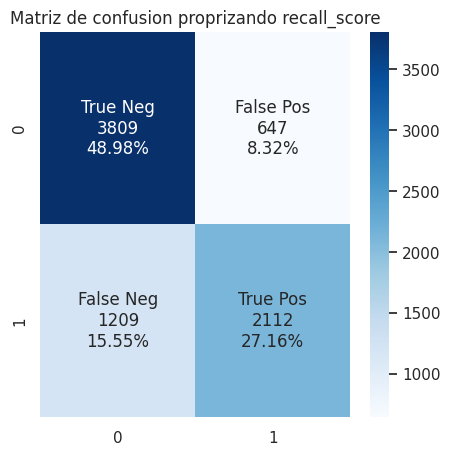

In [32]:
sns.set(rc={'figure.figsize': (5, 5)})

metrica_ = 'recall_score'

y_pred_arbol = grid_searches[f'{metrica_}'].predict(X)
cf_matrix = confusion_matrix(y, y_pred_arbol)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
# add title
plt.title(f'Matriz de confusion proprizando {metrica_}')

In [36]:
results = pd.DataFrame(grid_searches['recall_score'].cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
# se tienen en cuenta las medianas de cada metrica y ordenar por la metrica que se quiere optimizar
# Decision Tree Parameters

results[[
    'mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'mean_test_f1_score', 'param_max_depth', 'param_criterion', 'param_min_samples_split', 'param_min_samples_leaf'

    # ,'param_max_features'
    # ,'param_n_estimators'
]]

# SGD CLASSIFIER PARAMETERS
# results[[
#     'mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'mean_test_f1_score', 'param_loss', 'param_penalty', 'param_alpha', 'param_max_iter', 'param_tol'

#     # ,'param_max_features'
#     # ,'param_n_estimators'
# ]]

# export results of dataframe in csv
# .to_csv('results.csv', index=False)


,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,mean_test_f1_score,param_max_depth,param_criterion,param_min_samples_split,param_min_samples_leaf
0,0.760364,0.644225,0.761831,0.696959,1,gini,2,1
188,0.760364,0.644225,0.761831,0.696959,1,entropy,15,4
198,0.760364,0.644225,0.761831,0.696959,1,entropy,15,16
197,0.760364,0.644225,0.761831,0.696959,1,entropy,10,16
196,0.760364,0.644225,0.761831,0.696959,1,entropy,5,16
...,...,...,...,...,...,...,...,...
171,0.756444,0.623274,0.753944,0.682948,7,gini,5,16
172,0.756444,0.623274,0.753944,0.682948,7,gini,10,16
173,0.756444,0.623274,0.753944,0.682948,7,gini,15,16
174,0.756444,0.623274,0.753944,0.682948,7,gini,20,16


In [ ]:
# sirve para graficar recall y precision vs threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')


/home/cris/Documents/tp-grupal-3-marias/.venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


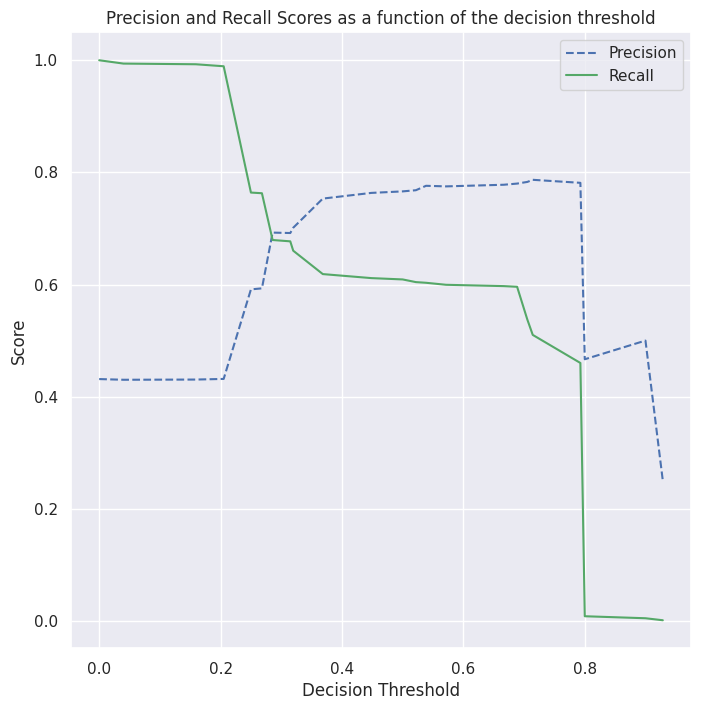

In [ ]:
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN) (True positive rate)
# FIXME:UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
# warnings.warn( TIRA ESTE ERROR POR QUE SON FEATURES CON HOTE ENCODING.
y_scores = grid_searches['precision_score'].predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, y_scores)
plot_precision_recall_vs_threshold(p, r, thresholds)


/home/cris/Documents/tp-grupal-3-marias/.venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


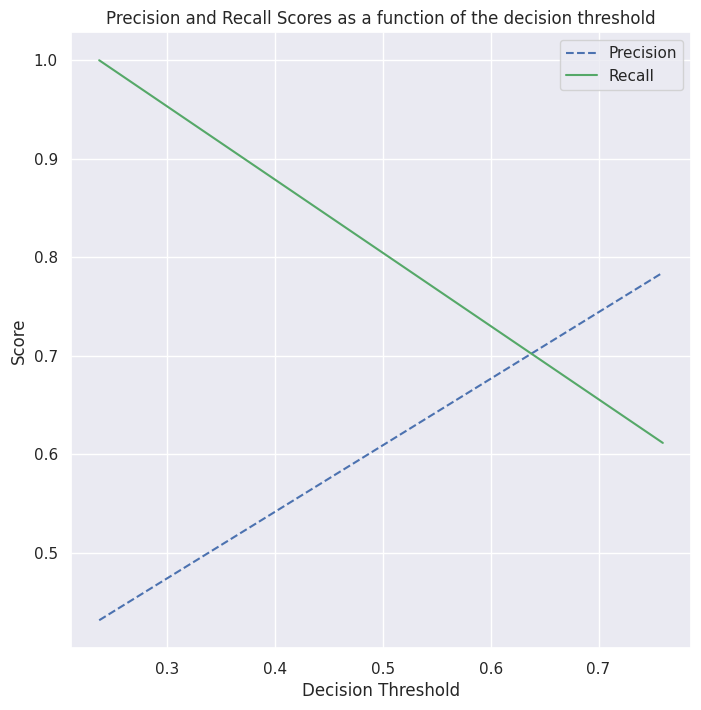

In [ ]:
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN) (True positive rate)
# FIXME:UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
# warnings.warn( TIRA ESTE ERROR POR QUE SON FEATURES CON HOTE ENCODING
y_scores = grid_searches['recall_score'].predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, y_scores)
plot_precision_recall_vs_threshold(p, r, thresholds)


In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8, 8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    # get random number between 0 and 1
    r = np.random.rand()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0, 1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')


/home/cris/Documents/tp-grupal-3-marias/.venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


0.7419778777369942


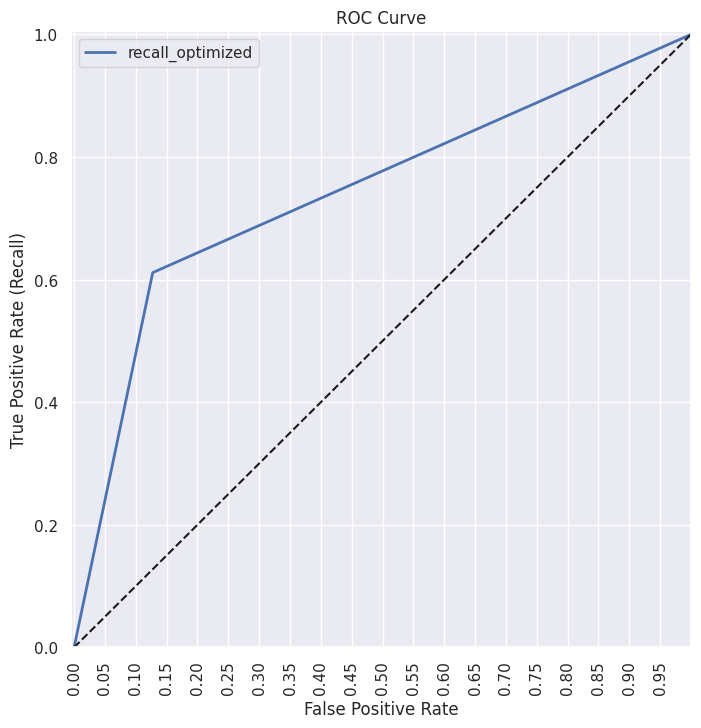

In [ ]:
# roc curve sirve para graficar recall en funcion de false positive rate y true positive rate
# La curva ROC(Receiver Operating Characteristic) es una representación gráfica que muestra la relación
# entre la tasa de verdaderos positivos(TPR) y la tasa de falsos positivos(FPR) al variar el umbral de clasificación del modelo.
# El AUC(Area Under the Curve) es el área bajo la curva ROC y proporciona una medida numérica de la calidad global del modelo de clasificación.
# El AUC varía entre 0 y 1, donde un AUC de 1 indica un modelo perfecto y un AUC de 0.5 indica rendimiento similar al azar.
y_scores = grid_searches['recall_score'].predict_proba(X_test)[:, 1]
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr))  # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')


In [ ]:

sns.set(rc={'figure.figsize': (10, 5)})


# importances with SGD
importances = np.abs(grid_searches['recall_score'].best_estimator_.coef_)[0]

# Importances with deccision tree
# importances = grid_searches['recall_score'].best_estimator_.feature_importances_


columns = X.columns
# reorder importances and columns variables so that they are sorted in descending order of importance
indices = np.argsort(importances)[::-1]
names = [columns[i] for i in indices]
# reorder list using a list of indices
importances = [importances[i] for i in indices]
columns = [columns[i] for i in indices]

# slice indices and importances after position 16
max_features = 15
columns = names[:max_features]
importances = importances[:max_features]
# print()

ax = sns.barplot(y=columns, x=importances, width=1)
plt.title('Importancia de cada Feature Para determinar si en un accidente hubo heridos/fallecidos o no')
# plt.xscale('log')
# xticks=ax.yaxis.get_major_ticks()
# for i in range(len(xticks)):
#     if i%2==1:
#         xticks[i].set_visible(False)
# plt.gca().invert_xaxis()
plt.show()
# revert axis
# set y axis in log scale

# get feature weights with its name


AttributeError: 'DecisionTreeClassifier' object has no attribute 'coef_'

In [ ]:
# clf.weights = grid_search_clf_tree.best_estimator_.feature_importances_
# get clf weights with feature names


In [ ]:
# # plot distribution of probabilities of a class
# plt.figure(figsize=(8, 8))
# plt.title('Distribution of probabilities of a class')
# plt.hist(y_scores, bins=10)
# plt.xlim(0, 1)
# plt.xlabel('Probability of a class')
# plt.ylabel('Number of occurrences')
# plt.show()


In [ ]:
# # plot locations of streets on the dataset using street name and number in argentina buenos aires map
# # https://www.google.com/maps/d/u/0/viewer?mid=1Q4Q1Z4Z1ZQ1Z4Z1Q4&ll=-34.60372200000001%2C-58.38159299999999&z=12
